In [4]:
from controlled_config import ControlledConfig
from rir_interface import taslp_RIR_Interface
from array_setup import array_setup_10cm_2mic
from locata_utils import cart2sph


import numpy as np
import matplotlib.pyplot as plt

In [2]:
rir_interface = taslp_RIR_Interface()

snr = -5
t60 = 0.2
src_mic_dist = 1.0
noi_mic_dist = 1.0
scenario = "source_moving"
test_config = ControlledConfig(array_setup=array_setup_10cm_2mic, snr=snr, t60=t60,
                                    src_mic_dist = src_mic_dist, noi_mic_dist = noi_mic_dist, 
                                    nb_points=16, same_plane=True)

for idx in range(0, 1):									
    retry_flag = True
    retry_count = 0
    while(retry_flag):
        try:
            static_config_dict = test_config._create_acoustic_scene_config("Static")
            circular_motion_config_dict = test_config._create_acoustic_scene_config("CircularMotion", scenario)
            retry_flag = False
        except AssertionError:
            retry_flag = True
            retry_count += 1	

config_dict = static_config_dict #circular_motion_config_dict
room_sz = config_dict['room_sz']
array_pos = config_dict['array_pos']
mic_pos = config_dict['mic_pos']
traj_pts= config_dict['src_traj_pts']
noise_pos= config_dict['noise_pos']
T60= config_dict['t60']
SNR= config_dict['snr']		

### Mapping config pos to keys of rir (Interface)

src_azimuth = np.degrees(cart2sph(traj_pts - array_pos)[:,2])
src_azimuth_keys = np.round(np.where(src_azimuth<0, 360+src_azimuth, src_azimuth)).astype('int32')	

source_rirs, dp_source_rirs = rir_interface.get_rirs(t60=T60, idx_list=list(src_azimuth_keys))

noi_azimuth = np.degrees(cart2sph(noise_pos - array_pos)[:,2])
noi_azimuth_keys = np.round(np.where(noi_azimuth<0, 360+noi_azimuth, noi_azimuth)).astype('int32')	
noise_rirs, _ = rir_interface.get_rirs(t60=T60, idx_list=list(noi_azimuth_keys))


In [3]:
src_azimuth, source_rirs.shape


(array([98.]), (1, 2, 4224))

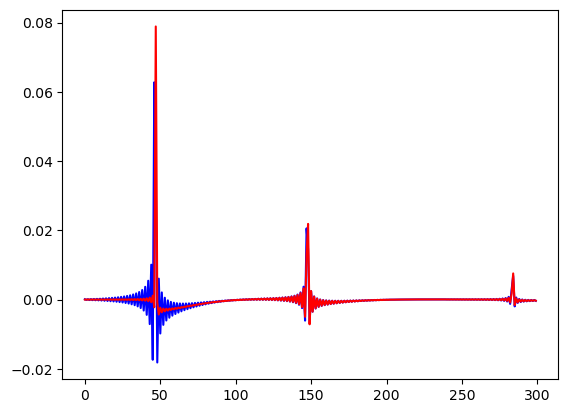

In [4]:
import matplotlib.pyplot as plt

plt.plot(source_rirs[0,0,:300],'b')
plt.plot(source_rirs[0,1,:300],'r')

In [5]:
source_rirs_86, dp_source_rirs_86 = rir_interface.get_rirs(t60=T60, idx_list=[86])

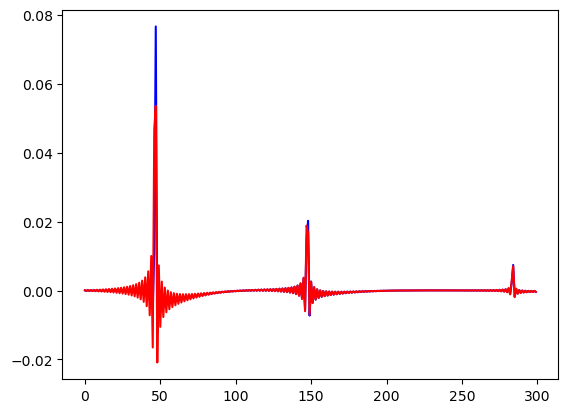

In [6]:
plt.plot(source_rirs_86[0,0,:300],'b')
plt.plot(source_rirs_86[0,1,:300],'r')

In [7]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

t60 = 0.2
files_list = f'/scratch/bbje/battula12/Databases/RIRs/taslp_roomdata_360_resolution_1degree/HABET_SpacedOmni_8x8x3_height1.5_dist1_roomT60_{t60}.mat'
rir = sio.loadmat(files_list)
_h = rir['trainingroom']

In [8]:
h = _h[0,86][0]
h.shape

(4224, 2)

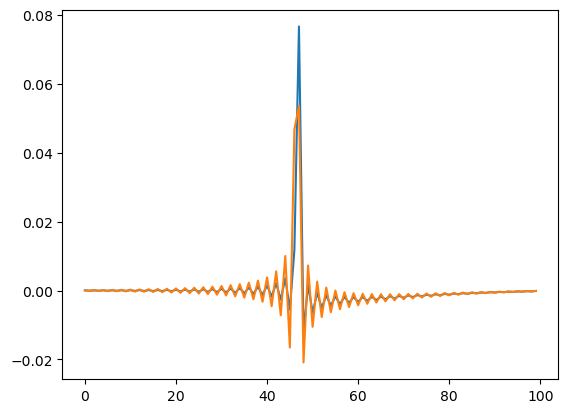

In [9]:
plt.plot(h[:100,0])
plt.plot(h[:100,1])

In [10]:

x = np.array(_h.tolist()).squeeze()
x_1 = np.transpose(x,(0,2,1))
x = np.transpose(x,(0,2,1))
x = x.astype('float32')

In [11]:
x.shape,

((361, 2, 4224),)

In [12]:
np.sum(x[86,:,0]**2), np.sum(x[86,:,1]**2), np.sum(x_1[86,0,:]**2), np.sum(x_1[86,1,:]**2)

(1.0016415e-08, 1.3814065e-08, 0.0076975921717922086, 0.007727222301348132)

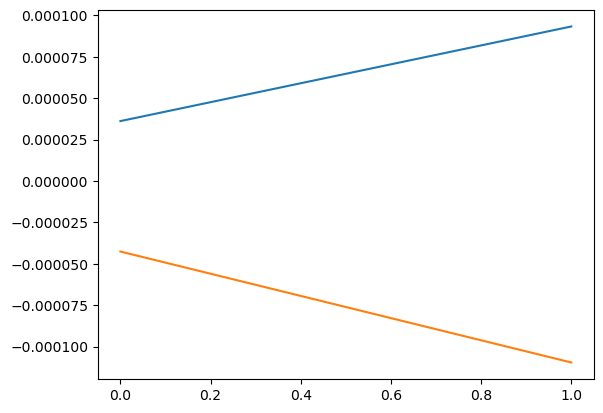

In [13]:
plt.plot(x[86,:,0])
plt.plot(x[86,:,1])

In [14]:
q1 = x[86,:,:]

In [15]:
q1.shape

(2, 4224)

In [16]:
import torch
q1 = torch.from_numpy(q1)
flip_q1 = torch.flip(q1, [1])

In [17]:
flip_q1.shape

torch.Size([2, 4224])

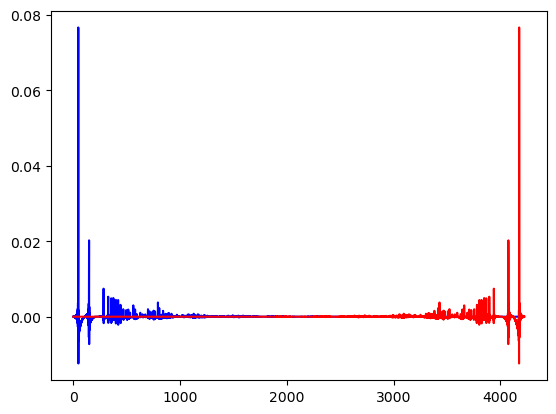

In [18]:
plt.plot(q1[0],'b')
plt.plot(flip_q1[0],'r')

In [19]:
import torchaudio
sig,fs = torchaudio.load('../signals/tgt_0.wav')

In [20]:
sig.shape

torch.Size([2, 64000])

In [21]:
q1 = x[86,:,:]
speech_ = torch.nn.functional.pad(sig[[0],:], (flip_q1.shape[1]-1, flip_q1.shape[1]-1))
augmented = torch.nn.functional.conv1d(speech_.unsqueeze(dim=1), flip_q1.unsqueeze(dim=1))


In [22]:
flip_q1.shape, speech_.shape

(torch.Size([2, 4224]), torch.Size([1, 72446]))

In [23]:
augmented.shape

torch.Size([1, 2, 68223])

In [24]:
speech_.shape

torch.Size([1, 72446])

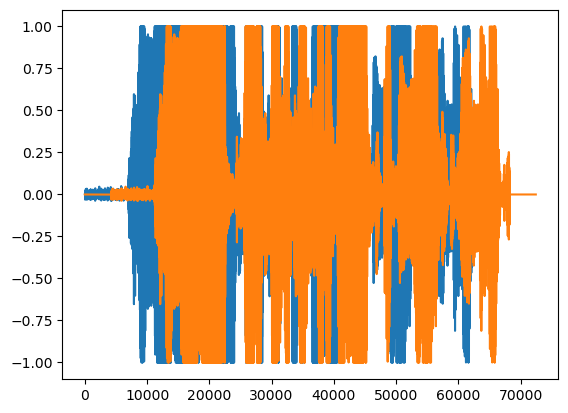

In [25]:
plt.plot(sig[0])
plt.plot(speech_[0])

In [26]:
augmented.shape

torch.Size([1, 2, 68223])

In [27]:
augmented[0]

tensor([[-1.4581e-09,  2.2589e-09, -4.3786e-09,  ...,  1.3251e-08,
         -1.3829e-09, -3.3317e-09],
        [-3.7597e-09,  5.8157e-09, -1.1268e-08,  ...,  5.3558e-09,
         -5.3423e-09, -1.1410e-09]])

In [28]:
ts = np.arange(16) * 64000 / 16000 / 16

In [29]:
blk_len = int(64000/16)


In [30]:
blk_len

4000

In [31]:
seg_sig = torch.nn.functional.unfold(sig[[0],:].unsqueeze(dim=1).unsqueeze(dim=1), kernel_size=(1, blk_len), padding=(0,0), stride=(1, blk_len))

In [32]:
seg_sig.shape

torch.Size([1, 4000, 16])

In [33]:
seg_sig = torch.permute(seg_sig,[0,2,1])

In [34]:
from scipy.signal import fftconvolve

In [35]:
speech_.shape, q1.shape

(torch.Size([1, 72446]), (2, 4224))

In [36]:
sph_rev = fftconvolve(speech_.numpy(), q1[[0],:], mode='valid')
sph_rev_2 = fftconvolve(sig[[0],:].numpy(), q1[[0],:], mode='full')

In [37]:
sph_rev_3 = fftconvolve(sig[[0],:].numpy(), q1, mode='full')


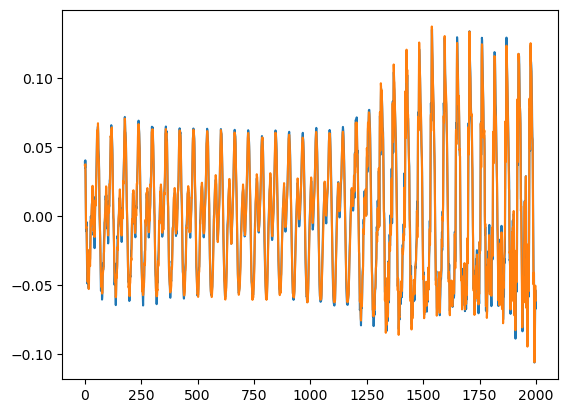

In [38]:
plt.plot(sph_rev_3[0,10000:12000])
plt.plot(sph_rev_3[1,10000:12000])

In [39]:
conv_out = augmented[0,[0],:].numpy()

In [40]:
import time

sig,fs = torchaudio.load('../signals/tgt_0.wav')
q1 = x[86,:,:]
q1 = torch.from_numpy(q1)
flip_q1 = torch.flip(q1, [1])

start = time.time()

speech_ = torch.nn.functional.pad(sig[[0],:], (flip_q1.shape[1]-1, flip_q1.shape[1]-1))
augmented = torch.nn.functional.conv1d(speech_.unsqueeze(dim=1), flip_q1.unsqueeze(dim=1))

end = time.time() - start

print(f"conv: {end}\n")

start = time.time()

sph_rev_2 = fftconvolve(sig[[0],:].numpy(), q1, mode='full')


fft_end = time.time() - start

print(f"fftconv: {fft_end}\n")


conv: 0.22225713729858398

fftconv: 0.005491495132446289



In [41]:
conv_out.dtype

dtype('float32')

In [42]:
sph_rev[0,12000], sph_rev_2[0,12000], conv_out[0,12000]

(-0.049677458, -0.049677454, -0.04967745)

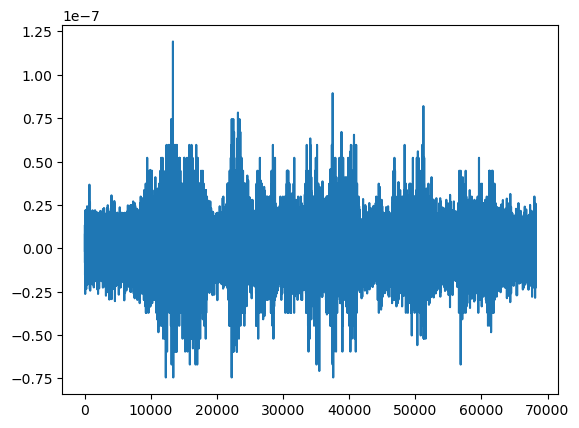

In [43]:
plt.plot(conv_out[0,:]-sph_rev_2[0,:])

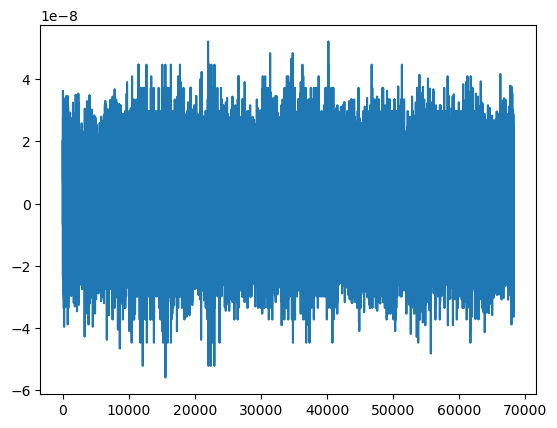

In [44]:
plt.plot(sph_rev[0,:]-sph_rev_2[0,:])


In [45]:
sph_rev.shape, sph_rev.dtype, sph_rev_2.shape, sph_rev_2.dtype 

((1, 68223), dtype('float32'), (2, 68223), dtype('float32'))

In [46]:
import torchaudio
mine_sig,fs = torchaudio.load('mine.wav')
gpuRIR_sig,fs = torchaudio.load('gpuRIR.wav')

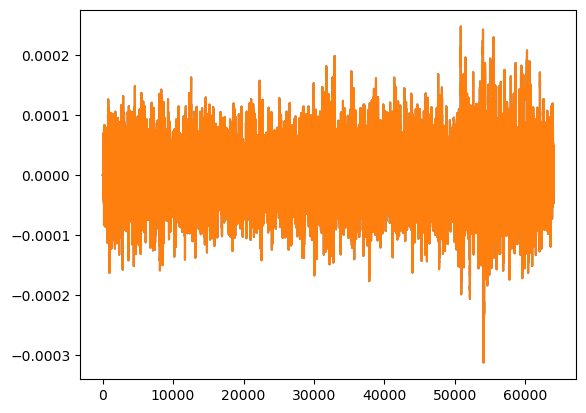

In [47]:
plt.plot(mine_sig[0])
plt.plot(gpuRIR_sig[0])

In [48]:
(gpuRIR_sig==mine_sig)[0].shape

torch.Size([64000])

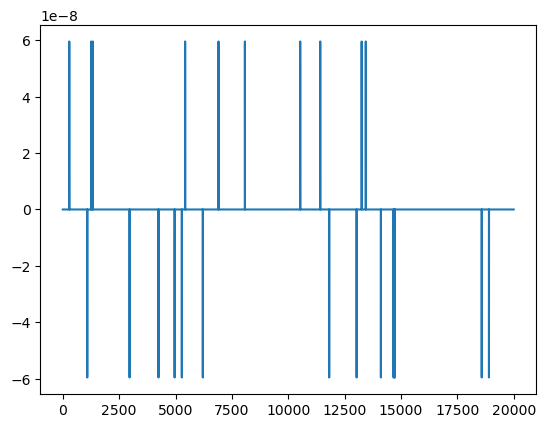

In [49]:
diff = (gpuRIR_sig-mine_sig)
plt.plot(diff[0,:20000])

In [50]:
torch.where(diff[0] !=0)

(tensor([  288,  1086,  1255,  1332,  2963,  4246,  4961,  5281,  5427,  6212,
          6908,  8078, 10531, 11419, 11816, 13033, 13257, 13439, 14110, 14670,
         14708, 14731, 18582, 18903, 23487, 23539, 25006, 25345, 28395, 29574,
         30546, 31163, 31403, 31631, 31828, 32989, 33167, 33711, 37259, 37712,
         39646, 40606, 43816, 44594, 44875, 45800, 45870, 49198, 49621, 49931,
         51660, 52183, 52993, 53448, 53454, 53645, 54123, 54624, 54997, 55244,
         55756, 56180, 56194, 56712, 60687, 60800, 61291, 63735, 63850]),)

In [51]:
diff[0,45800]

tensor(5.9605e-08)

In [52]:
gpuRIR_sig.shape

torch.Size([2, 64000])

In [53]:
diff = (gpuRIR_sig==mine_sig)


In [54]:
(torch.where(diff[0] == False))[0].shape

torch.Size([69])

In [55]:
torch.where(diff[0] == False)

(tensor([  288,  1086,  1255,  1332,  2963,  4246,  4961,  5281,  5427,  6212,
          6908,  8078, 10531, 11419, 11816, 13033, 13257, 13439, 14110, 14670,
         14708, 14731, 18582, 18903, 23487, 23539, 25006, 25345, 28395, 29574,
         30546, 31163, 31403, 31631, 31828, 32989, 33167, 33711, 37259, 37712,
         39646, 40606, 43816, 44594, 44875, 45800, 45870, 49198, 49621, 49931,
         51660, 52183, 52993, 53448, 53454, 53645, 54123, 54624, 54997, 55244,
         55756, 56180, 56194, 56712, 60687, 60800, 61291, 63735, 63850]),)

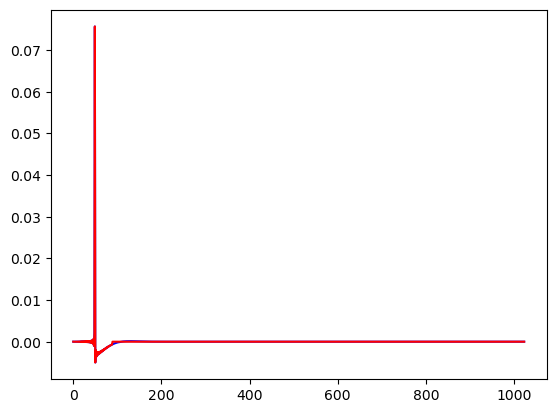

In [5]:
rir_interface = taslp_RIR_Interface()
rirs, dp_rirs = rir_interface.get_rirs(t60=0.0, idx_list=[4])

plt.plot(rirs[0,0,:], 'b')
plt.plot(dp_rirs[0,0,:], 'r')

In [6]:
np.where(rirs[0,0,:]==dp_rirs[0,0,:])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]),)

In [7]:
rirs[0,0,89:]

array([-6.14584191e-04, -5.95297373e-04, -5.22268587e-04, -5.01372037e-04,
       -4.37324430e-04, -4.15470073e-04, -3.59654281e-04, -3.37401434e-04,
       -2.89088523e-04, -2.66917254e-04, -2.25398515e-04, -2.03720818e-04,
       -1.68308252e-04, -1.47477316e-04, -1.17504853e-04, -9.78228709e-05,
       -7.26478684e-05, -5.43725218e-05, -3.33774697e-05, -1.67274266e-05,
        6.78339916e-07,  1.55188482e-05,  2.98974974e-05,  4.27748128e-05,
        5.46584633e-05,  6.54653486e-05,  7.52617998e-05,  8.40950961e-05,
        9.20117818e-05,  9.90576300e-05,  1.05277519e-04,  1.10715388e-04,
        1.15414186e-04,  1.19415803e-04,  1.22761034e-04,  1.25489532e-04,
        1.27639811e-04,  1.29249136e-04,  1.30353626e-04,  1.30988134e-04,
        1.31186272e-04,  1.30980407e-04,  1.30401662e-04,  1.29479944e-04,
        1.28243875e-04,  1.26720857e-04,  1.24937098e-04,  1.22917583e-04,
        1.20686098e-04,  1.18265278e-04,  1.15676594e-04,  1.12940412e-04,
        1.10075984e-04,  

In [1]:
import numpy as np
t60_list = [round(i,1) for i in np.arange(0, 1.1, 0.1) if i != 0.1]

In [23]:
f_reverb = open('../dataset_file_circular_motion_snr_-5_t60_0.2_reverb.txt', 'w')
with open('../dataset_file_circular_motion_snr_-5_t60_0.2.txt', 'r') as f:
    for line in f.readlines():  
        #print(line)
        t60 = np.random.choice(t60_list)
        app_t60_str = f',{t60}\n'
        _line = line.strip()+app_t60_str
        #print(_line)
        f_reverb.write(_line)
        #break


f_reverb.close()

In [15]:
type(line)

str

In [2]:
with open('../Logs/inputs/reverb/input-1.txt', 'r') as f:
    lines = [line for line in f.readlines()]

#key value 
for line in lines:
    lst = line.strip().split()
    if lst[0]=="T60":
        T60 = float(lst[1])
    elif lst[0]=="dataset_dtype":
        dataset_dtype = lst[1]

In [4]:
T60, type(T60)

(0.0, float)

In [5]:
dataset_dtype, type(dataset_dtype)

('stationary', str)

In [6]:
f_reverb = open('../val_dataset_file_circular_motion_snr_-5_t60_0.2_noisy.txt', 'w')
with open('../val_dataset_file_circular_motion_snr_-5_t60_0.2.txt', 'r') as f:
    for line in f.readlines():  
        #print(line)
        snr = np.random.uniform(-5.0,5.01)
        app_snr_str = f',{snr}\n'
        _line = line.strip()+app_snr_str
        #print(_line)
        f_reverb.write(_line)
        #break


f_reverb.close()

In [5]:
import numpy as np


2.5362795910949343

In [3]:
f_reverb = open('../dataset_file_circular_motion_snr_-5_t60_0.2_noisy_reverb.txt', 'w')
with open('../dataset_file_circular_motion_snr_-5_t60_0.2.txt', 'r') as f:
    for line in f.readlines():  
        #print(line)
        snr = np.random.uniform(-5.0,5.01)
        t60 = np.random.choice(t60_list)
        app_snr_str = f',{snr},{t60}\n'
        _line = line.strip()+app_snr_str
        #print(_line)
        f_reverb.write(_line)
        #break


f_reverb.close()

In [2]:
snr_list = [-5, 0, 5, 10, 20]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]

idx=1
for snr in snr_list:
    for t60 in t60_list:
        name = f'../Logs/inputs/noisy_reverb/input-{idx}.txt'
        f = open(name, 'w')
        f.write(f'SNR {snr}\n')
        f.write(f'T60 {t60}\n')
        f.close()
        idx +=1


In [5]:
#import torch
#torch.save(exp_dict, "noisy_reverb_results.pt")


In [28]:
lst = pesq_line.split()

In [2]:
def get_test_config_details(lst):
    ckpt_name_list = lst[1].split('/')
    train, mic_idx = ckpt_name_list[-3], ckpt_name_list[-1][-2]

    exp_name_list = lst[-1].split('_')
    #idx = 4 if exp_name_list[-1][0]=='-' else 3
    snr, t60, test = exp_name_list[-1][:-3], exp_name_list[-3], exp_name_list[-5]

    return mic_idx, train, test, t60, snr

In [12]:
mic_idx=1
t60 = 0.2
train = 'stationary'
test = 'stationary'
snr = 5.0

# for snr in snr_list:
for t60 in t60_list:
    for test in scenarios:
        key_str = f'train_{train}_mic_idx_{mic_idx}_test_{test}_t60_{t60}_snr_{snr}'
        print(exp_dict[key_str])

metrics(mix_stoi='0.7932829968536118', enh_stoi='0.9556406211289186', mix_pesq_nb='1.9525068918655426', enh_pesq_nb='3.2815649984343667')
metrics(mix_stoi='0.7932015723153147', enh_stoi='0.9479800249882028', mix_pesq_nb='1.952262470691658', enh_pesq_nb='3.2367759349517398')
metrics(mix_stoi='0.7258314764997562', enh_stoi='0.9248804984382581', mix_pesq_nb='1.77705178067142', enh_pesq_nb='2.9267698130876165')
metrics(mix_stoi='0.7251959976577924', enh_stoi='0.9159838731411077', mix_pesq_nb='1.7740615844996839', enh_pesq_nb='2.8886839348906124')
metrics(mix_stoi='0.6731365766845931', enh_stoi='0.9035247210425655', mix_pesq_nb='1.6405535389192543', enh_pesq_nb='2.732812800315423')
metrics(mix_stoi='0.6717580665517088', enh_stoi='0.8929985213562168', mix_pesq_nb='1.6344821296698777', enh_pesq_nb='2.6901165937541096')
metrics(mix_stoi='0.6308723049141277', enh_stoi='0.884576735857066', mix_pesq_nb='1.5389965827572865', enh_pesq_nb='2.5907749875172175')
metrics(mix_stoi='0.6289346372738357', 

In [14]:
import torch
exp_dict = torch.load('../Logs/noisy_reverb/noisy_reverb_results.pt')

mic_idx=1
train = 'stationary'
snr = 20.0
# for snr in snr_list:
for t60 in t60_list:
    for test in scenarios:
        key_str = f'train_{train}_mic_idx_{mic_idx}_test_{test}_t60_{t60}_snr_{snr}'
        print(f'{t60}, {test}, {exp_dict[key_str]}')

0.2, stationary, metrics(mix_stoi='0.9378978164791439', enh_stoi='0.9836030431741604', mix_pesq_nb='2.9288958782586767', enh_pesq_nb='3.7416012741984788')
0.2, moving, metrics(mix_stoi='0.9377405464703217', enh_stoi='0.971195894640467', mix_pesq_nb='2.9236625190651635', enh_pesq_nb='3.6306214628354443')
0.4, stationary, metrics(mix_stoi='0.8465379058247801', enh_stoi='0.9625528632701136', mix_pesq_nb='2.3038931461075265', enh_pesq_nb='3.313836451326609')
0.4, moving, metrics(mix_stoi='0.8451274673676219', enh_stoi='0.9502582316667803', mix_pesq_nb='2.291172126433434', enh_pesq_nb='3.2321849679048493')
0.6, stationary, metrics(mix_stoi='0.7745293940427381', enh_stoi='0.9447201272314256', mix_pesq_nb='2.001685444547319', enh_pesq_nb='3.070477709568447')
0.6, moving, metrics(mix_stoi='0.7721582538879088', enh_stoi='0.9311921404908593', mix_pesq_nb='1.9912193042798239', enh_pesq_nb='2.9907036747959044')
0.8, stationary, metrics(mix_stoi='0.7178541954043912', enh_stoi='0.9276302594044826', 

In [2]:
# real to complex
import torch
a = torch.rand(2,2,5,6)

c = torch.complex(a[:,0,:,:], a[:,1,:,:])


In [3]:
c.shape


torch.Size([2, 5, 6])

In [4]:
a

tensor([[[[0.2884, 0.9791, 0.1443, 0.4301, 0.0657, 0.2952],
          [0.6876, 0.5006, 0.8689, 0.4273, 0.9852, 0.2200],
          [0.0852, 0.4677, 0.1905, 0.3688, 0.3299, 0.8496],
          [0.1522, 0.8648, 0.4136, 0.0081, 0.3690, 0.5925],
          [0.0589, 0.8237, 0.3887, 0.9330, 0.4346, 0.7129]],

         [[0.2587, 0.3350, 0.2561, 0.0974, 0.8009, 0.6094],
          [0.7568, 0.3085, 0.6937, 0.1217, 0.0455, 0.8260],
          [0.5195, 0.3826, 0.5647, 0.9241, 0.0532, 0.2650],
          [0.7557, 0.6968, 0.5475, 0.3662, 0.7282, 0.3126],
          [0.0237, 0.4199, 0.1480, 0.5674, 0.0974, 0.8543]]],


        [[[0.6008, 0.8285, 0.9999, 0.0062, 0.0219, 0.6174],
          [0.9368, 0.5325, 0.1305, 0.1946, 0.4461, 0.3387],
          [0.3507, 0.6874, 0.8368, 0.7892, 0.1558, 0.0391],
          [0.7447, 0.1811, 0.0154, 0.9953, 0.7219, 0.5939],
          [0.9319, 0.3829, 0.6450, 0.6300, 0.3607, 0.2196]],

         [[0.5414, 0.8072, 0.6004, 0.8605, 0.7611, 0.0894],
          [0.8181, 0.4999, 0.786

In [5]:
c


tensor([[[0.2884+0.2587j, 0.9791+0.3350j, 0.1443+0.2561j, 0.4301+0.0974j,
          0.0657+0.8009j, 0.2952+0.6094j],
         [0.6876+0.7568j, 0.5006+0.3085j, 0.8689+0.6937j, 0.4273+0.1217j,
          0.9852+0.0455j, 0.2200+0.8260j],
         [0.0852+0.5195j, 0.4677+0.3826j, 0.1905+0.5647j, 0.3688+0.9241j,
          0.3299+0.0532j, 0.8496+0.2650j],
         [0.1522+0.7557j, 0.8648+0.6968j, 0.4136+0.5475j, 0.0081+0.3662j,
          0.3690+0.7282j, 0.5925+0.3126j],
         [0.0589+0.0237j, 0.8237+0.4199j, 0.3887+0.1480j, 0.9330+0.5674j,
          0.4346+0.0974j, 0.7129+0.8543j]],

        [[0.6008+0.5414j, 0.8285+0.8072j, 0.9999+0.6004j, 0.0062+0.8605j,
          0.0219+0.7611j, 0.6174+0.0894j],
         [0.9368+0.8181j, 0.5325+0.4999j, 0.1305+0.7868j, 0.1946+0.3605j,
          0.4461+0.8920j, 0.3387+0.1927j],
         [0.3507+0.2421j, 0.6874+0.7250j, 0.8368+0.3750j, 0.7892+0.6845j,
          0.1558+0.8482j, 0.0391+0.7606j],
         [0.7447+0.9721j, 0.1811+0.6930j, 0.0154+0.7989j, 0.99